# Exploratory Data Analysis

## Imports

In [128]:
import os

# data handling
import re
import xarray   as xr
import numpy    as np
import pandas   as pd

# plotting
import seaborn              as sbn
import matplotlib.pyplot    as pyp
import cartopy.crs          as ccrs
import cartopy.feature      as cfeature

## Loading the data

In [124]:
df = pd.read_csv('./WWIII-bulk_params,1D_spec-fall_2021.csv')

## Goals

This dataset constists of bulk wave parameters and 1-D wave spectra from a collection of grid points output by the spectral wave model WAVEWATCH III. For a specific set of grid points that are colocated wiht the locations of real-life CDIP buoys, I extracted the bulk wave paramters output by the model. The model was run during 3 Fall months. Typically, spectral wave models model the wave spectrum but only output bulk wave paramters to save on space. However, this model run was told to output spectra at those CDIP buoy locations, which allowed me to construct this dataset with collocated bulk parameters and spectra. In the past, I've tried to use ML to predict the wave spectrum with the bulk paramters (which is a porblem I would like to explore more later in this class). However, this dataset also consists of spectra representing different sea states, which I would like to investigate here.

Basically, I want to see if I can use a clustering algorithm to group wave spectra or bulk parameters by sea state. Example sea states might be:
1) Remote swell propogating in from far away,
2) A fully developed mixed sea where local winds have generated waves of all wavelength,
3) Dual wave system where two distinct wave groups are interacting at a single point.

There are many more examples of types of sea states. Each sea state will produce a unique spectral shape, and may produce distinct bulk wave parameters. My goal is to see if a clustering ML alogorithm can pick up on these trends to group by sea state. My prediction is that it won't work! But it's a fun problem to explore.

## Intial statistics

In [63]:
df.shape

(9510, 17)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9510 entries, 0 to 9509
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               9510 non-null   int64  
 1   station_name             9510 non-null   object 
 2   latitude                 9510 non-null   float64
 3   longitude                9510 non-null   float64
 4   time                     9510 non-null   object 
 5   wind_speed               9510 non-null   float64
 6   wind_direction           9510 non-null   float64
 7   significant_wave_height  9510 non-null   float64
 8   t02                      9510 non-null   float64
 9   t0m1                     9510 non-null   float64
 10  t01                      9510 non-null   float64
 11  peak_frequency           9510 non-null   float64
 12  direction                9510 non-null   float64
 13  directional_spread       9510 non-null   float64
 14  stokes_drift            

In [64]:
df.describe()

,Unnamed: 0,latitude,longitude,wind_speed,wind_direction,significant_wave_height,t02,t0m1,t01,peak_frequency,direction,directional_spread,stokes_drift,mean_square_slope
count,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000
mean,4754.500000,34.885000,-121.000000,5.737519,282.499520,1.966432,6.935168,10.312187,8.269723,0.082249,277.924619,39.465227,0.053077,0.005271
std,2745.444864,1.511268,1.271772,3.198478,77.904698,0.927467,1.616876,1.686924,1.724841,0.022347,27.766470,9.755083,0.042620,0.003927
min,0.000000,33.210000,-123.460000,0.024583,0.003723,0.685627,3.705002,6.240794,4.525717,0.048062,187.845703,15.121512,0.000108,0.000147
25%,2377.250000,33.760000,-121.480000,3.202631,279.513917,1.330551,5.674877,9.100220,6.963282,0.066915,261.282883,31.999041,0.019470,0.001886
50%,4754.500000,34.605000,-120.815000,5.235750,312.972595,1.785405,6.704982,10.285147,8.161410,0.078298,287.251251,39.134956,0.040063,0.004236
75%,7131.750000,35.190000,-119.870000,7.826772,326.678575,2.350802,8.051784,11.459931,9.431867,0.090709,299.581360,46.908927,0.076580,0.008180
max,9509.000000,37.940000,-119.560000,18.856606,359.995800,7.520592,12.164914,15.667164,13.811975,0.207452,322.620178,70.175720,0.244949,0.019032


In [70]:
df = df.drop('Unnamed: 0', axis=1)

In [71]:
df.head()

,station_name,latitude,longitude,time,wind_speed,wind_direction,significant_wave_height,t02,t0m1,t01,peak_frequency,direction,directional_spread,stokes_drift,mean_square_slope,spectrum
0,CDIP_067,33.21,-119.87,2021-09-01 00:00:00,4.799718,266.66530,1.711951,7.118798,9.263160,8.194286,0.101551,296.726990,49.508770,0.029423,0.003071,[5.8242294e-04 9.8529011e-03 2.8716663e-02 4.3...
1,CDIP_067,33.21,-119.87,2021-09-01 01:00:00,4.946980,276.83112,1.717859,7.046659,9.253114,8.150838,0.101784,296.649414,49.686054,0.030717,0.003202,[5.4895459e-04 9.3895569e-03 2.8347341e-02 4.3...
2,CDIP_067,33.21,-119.87,2021-09-01 02:00:00,5.390134,276.42953,1.707501,6.853151,9.239675,8.050937,0.102171,295.837341,50.035194,0.033368,0.003619,[5.12511295e-04 8.91093258e-03 2.79220473e-02 ...
3,CDIP_067,33.21,-119.87,2021-09-01 03:00:00,5.606437,288.53687,1.706872,6.642603,9.182423,7.905410,0.103012,295.193604,50.188240,0.036883,0.004040,[4.4655573e-04 8.4560169e-03 2.7594399e-02 4.4...
4,CDIP_067,33.21,-119.87,2021-09-01 04:00:00,4.259069,302.98456,1.709024,6.778125,9.172662,7.962517,0.103711,294.964417,50.576324,0.033617,0.003495,[3.58059420e-04 7.89791346e-03 2.77876742e-02 ...


This dataset has about 10,000 entries, making in a solid size for this project. There 16 features in this dataset: the name of the buoy that the model grid cell is closest to, the lat/lon of that grid cell, the time stamp of the model output, the wind speed, the wind direction, the significant wave height ($H_s$), a few mean periods for different spectral moments (t02, t0m1, t01), peak frequency ($f_p$), peak direction from the 2-D spectrum (direction), directional spreading of the 2-D spectrum, the Stokes drift, the mean square slope, and the 1-D spectral curve.

## Heatmap

In [75]:
df.columns.tolist()

['station_name',
 'latitude',
 'longitude',
 'time',
 'wind_speed',
 'wind_direction',
 'significant_wave_height',
 't02',
 't0m1',
 't01',
 'peak_frequency',
 'direction',
 'directional_spread',
 'stokes_drift',
 'mean_square_slope',
 'spectrum']

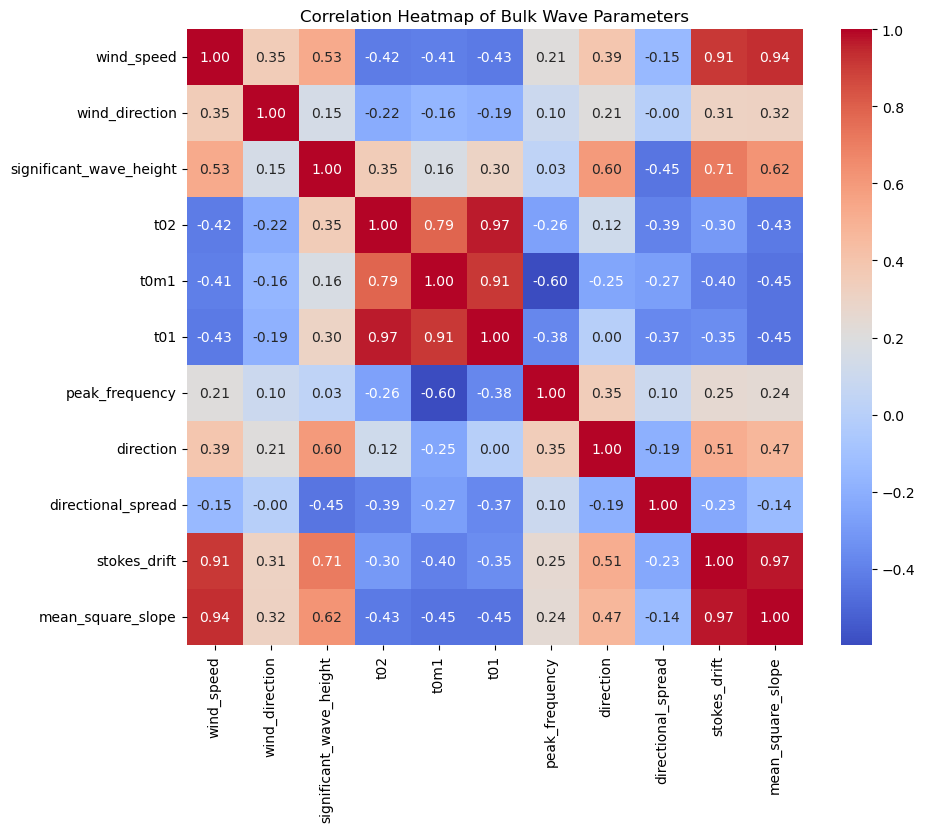

In [98]:
# extract bulk wave parameters
bulk_wave_params = [
'wind_speed',
 'wind_direction',
 'significant_wave_height',
 't02',
 't0m1',
 't01',
 'peak_frequency',
 'direction',
 'directional_spread',
 'stokes_drift',
 'mean_square_slope'
]

# correlation matrix
corr_matrix = df[bulk_wave_params].corr()

# plot
pyp.figure(figsize=(10, 8))
sbn.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
pyp.title('Correlation Heatmap of Bulk Wave Parameters')
pyp.show()

This heatmap shows some interesting relationships between the bulk wave parameters (and the wind speed and direcion, which are not wave parameters). There is a very high correlation between the Stokes drift and wind speed. The Stokes drift is driven mainly by local winds, which explains this correlation. The same is true for the wind speed and the mean square slope. There is also a pretty high correlation between the significant wave height and the Stokes drift and mean square slope. Generally, higher waves (higher significant wave height) leads to steeper waves (higher mean square slope) and steeper waves have a higher Stokes drift. There is almost a correlation of 1 between the Stokes drift and mean square slope for this reason. All the different peak periods (t0xx) are related and correlated to some degree becaause they are calculated in a similar way. The peak period t0m1 is highly negatively correlated with the peak frequency because they are nearly inversely related. Lastly, there is an interestingly high correlation between the significant wave height and the peak direction (direction). This correlation means that as one increases, the other is likely to increase. I think what this might be explaining is that higher waves typically come from closer North, which might be explained by the fact that powerful storms propogate in from the N-NW during the time of year that this model was run.

## Box and whisker plots

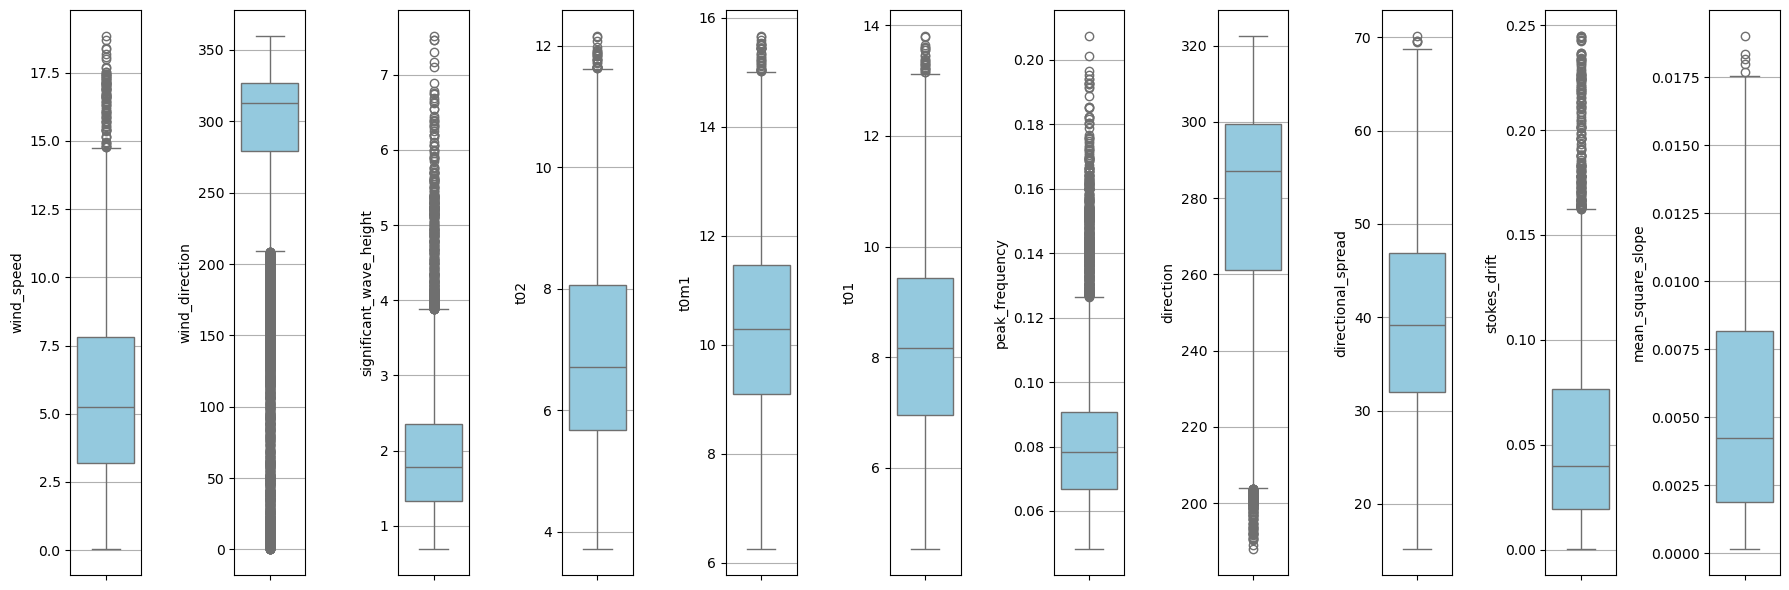

In [100]:
# initialize plot
fig, axes = pyp.subplots(nrows=1, ncols=len(bulk_wave_params), figsize=(18, 6), sharex=False)

# plot each parameter w/ their own y-axis
for i, param in enumerate(bulk_wave_params):
    sbn.boxplot(y=df[param], ax=axes[i], color='skyblue')
    axes[i].grid(axis='y')

# plot
pyp.tight_layout()
pyp.show()

These plots just show what each bulk parameter's spread of values is like. Given the time of year and domain, these values look reasonable.

## Grid cell locations

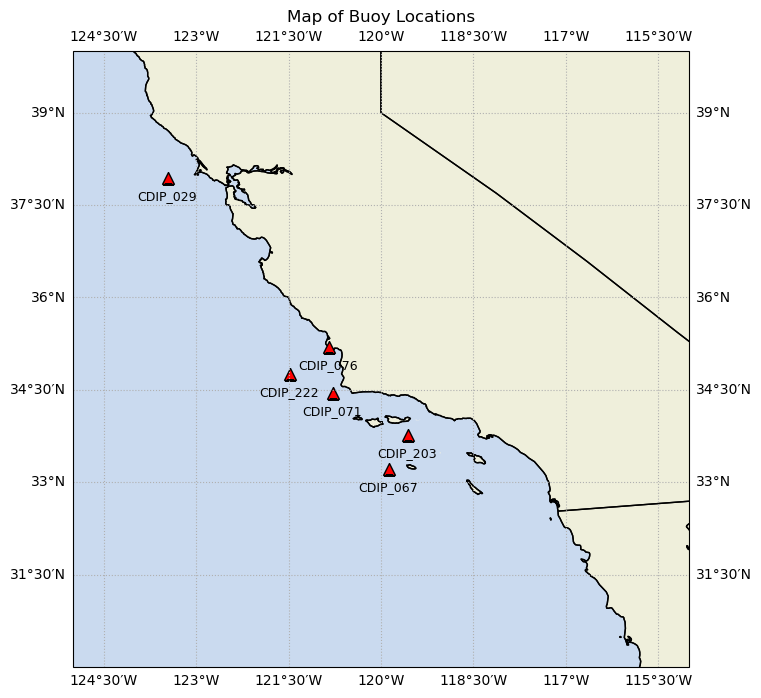

In [120]:
# group data by buoy name and extract the lat/lon
buoy_locs = df.groupby('station_name')[['latitude', 'longitude']].mean().reset_index()

# map init
pyp.figure(figsize=(12, 8))
ax = pyp.axes(projection=ccrs.PlateCarree())
ax.set_extent([-125, -115, 30, 40], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.OCEAN, alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle=':')

# plot buoy locs
for _, row in buoy_locs.iterrows():
    ax.plot(row['longitude'], row['latitude'], 
        marker='^', markersize=8, color='red', markeredgecolor='black', markeredgewidth=1,
        transform=ccrs.PlateCarree()
    )    
    ax.text(
        row['longitude'] - 0.5, row['latitude'] - 0.35,
        row['station_name'],
        transform=ccrs.PlateCarree(),
        fontsize=9, color='black'
    )
pyp.title('Map of Buoy Locations')
pyp.show()

This plot shows what grid points I have data for. The model ran at every grid point in this domain, but spectra were only saved at the red triangles. One consideration to make here is that most of these locations are relatively coastal.

## Mean spectra

First, we need to parse the spectral data to an array (it saved as a string).

In [125]:
def parse_efth(entry):
    cleaned_entry = re.sub(r'[\[\]\n]', ' ', entry).strip()
    return np.array([float(value) for value in cleaned_entry.split()])

In [126]:
df['spectrum'] = df['spectrum'].apply(parse_efth)

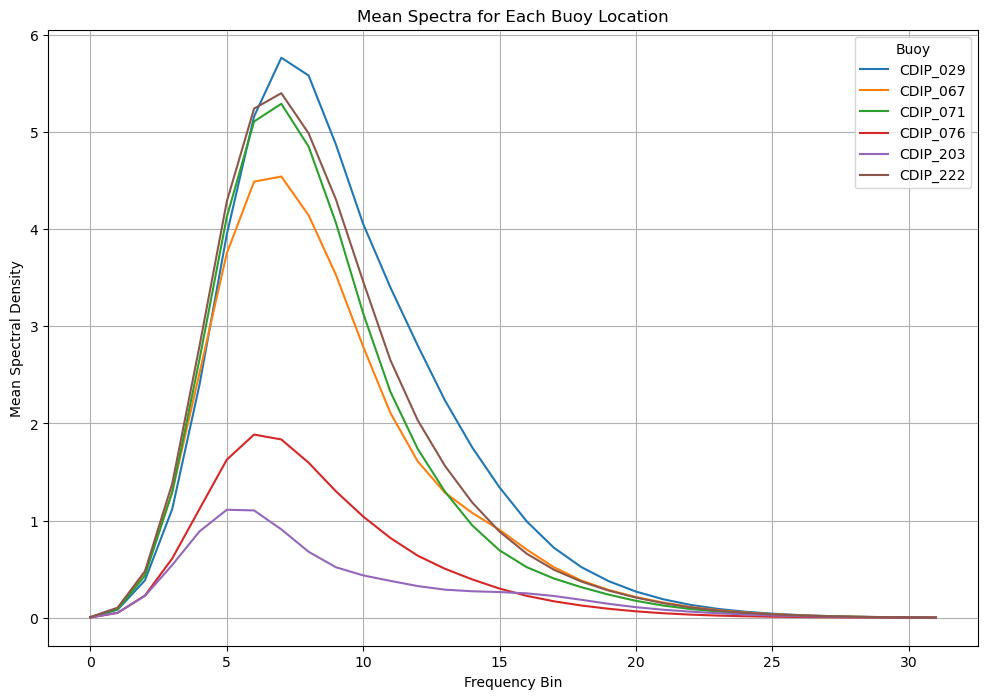

In [129]:
# group my station and take mean across time
mean_spectra = df.groupby('station_name')['spectrum'].apply(lambda x: np.mean(np.stack(x), axis=0))

# plot init
pyp.figure(figsize=(12, 8))

# plot mean spectrum
for station, spectrum in mean_spectra.items():
    pyp.plot(range(len(spectrum)), spectrum, label=station)

# labels and show
pyp.xlabel('Frequency Bin')
pyp.ylabel('Mean Spectral Density')
pyp.title('Mean Spectra for Each Buoy Location')
pyp.legend(title='Buoy')
pyp.grid()
pyp.show()

The mean spectra for each buoy location smoothes out almost all the interesting features that I want to cluster. The two interesting trends to see here though are the relative energy levels for each buoy location and the slightly offset peak frequencies for each.

## Spectrum Evolution

To showcase different sea states that I might want to group by, an animated figure would probably be better. Below is code that generates frames for the spectrum of a single buoy location, CDIP 029.

In [130]:
freqs = np.array([0.0373, 0.04103, 0.045133, 0.049646, 0.054611, 0.060072, 0.066079,
                         0.072687, 0.079956, 0.087951, 0.096747, 0.106421, 0.117063, 0.12877,
                         0.141647, 0.155811, 0.171393, 0.188532, 0.207385, 0.228123, 0.250936,
                         0.276029, 0.303632, 0.333996, 0.367395, 0.404135, 0.444548, 0.489003,
                         0.537903, 0.591694, 0.650863, 0.715949])

In [134]:
# filter for CDIP 029
buoy_name = "CDIP_029"
buoy_data = df[df['station_name'] == buoy_name].sort_values('time')

# convert the time column to datetime if it is not already
buoy_data['time'] = pd.to_datetime(buoy_data['time'])

# extract spectrum and time
spectra = buoy_data['spectrum'].values
times = buoy_data['time'].dt.strftime('%Y-%m-%d %H:%M:%S').values

# output
output_folder = "spectrum_plots"
os.makedirs(output_folder, exist_ok=True)

# loop for each time step
for i, spectrum in enumerate(spectra):
    pyp.figure(figsize=(10, 6))
    pyp.loglog(freqs, spectrum, color='blue', lw=2)
    pyp.title(f"Spectrum at Time: {times[i]}")
    pyp.ylim(1e-3, 10)
    pyp.xlabel("Frequency Bin")
    pyp.ylabel("Spectral Density")
    pyp.grid(True)
    
    # save/close
    output_path = os.path.join(output_folder, f"spectrum_{i:04d}.png")
    pyp.savefig(output_path, dpi=300)
    pyp.close()

print(f"Plots saved to folder: {output_folder}")

Plots saved to folder: spectrum_plots


This movie shows ho a wave spectrum can evolve and the different sea states they can represent. In this movie, we can see sometimes the spectrum is characterized by 2 distinct wave systems (2 peaks in the spectrum), sometimes its very skinny, indicating that waves outside the domain have propogated in and are organized into frequency groups because of wave dispersion, sometimes the spectrum is very broad/fat, indicating that there are local winds generating all types of waves. These are the types of wave states that I want to see if a clustering algorithm can sort into groups.